<a href="https://colab.research.google.com/github/dostonshernazarov/rice_type_classification/blob/main/rice_type_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
get_ipython().run_line_magic('pip', 'install opendatasets --quiet')
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mssmartypants/rice-type-classification")

Skipping, found downloaded files in "./rice-type-classification" (use force=True to force download)


In [4]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
data_df = pd.read_csv('/content/rice-type-classification/riceClassification.csv')
data_df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [7]:
data_df.dropna(inplace=True)
data_df.drop(['id'], axis=1, inplace=True)
print(data_df.shape)

(18185, 11)


In [8]:
data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [10]:
print(data_df['Class'].value_counts())
print("Unique items: ", data_df['Class'].unique())

Class
1    9985
0    8200
Name: count, dtype: int64
Unique items:  [1 0]


In [11]:
org_df = data_df

for column in data_df.columns:
  data_df[column] = data_df[column]/data_df[column].abs().max()

data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


In [12]:
X = np.array(data_df.drop(['Class'], axis=1))
y = np.array(data_df['Class'])

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.3)

In [14]:
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size = 0.5)

In [16]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(12729, 10)
(2728, 10)
(2728, 10)


In [17]:
class dataset(Dataset):
  def __init__(self, X, y):
    self.X = torch.tensor(X, dtype=torch.float32).to(device)
    self.y = torch.tensor(y, dtype=torch.float32).to(device)

  def __getitem__(self, index):
    return self.X[index], self.y[index]

  def __len__(self):
    return len(self.X)


In [18]:
training_data = dataset(X_train, Y_train)
testing_data = dataset(X_test, Y_test)
validation_data = dataset(X_val, Y_val)

In [32]:
train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(testing_data, batch_size=32, shuffle=True)
val_dataloader = DataLoader(validation_data, batch_size=32, shuffle=True)

In [33]:
HIDDEN_NEURONS = 10
class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()

    self.input_layer = nn.Linear(X.shape[1], HIDDEN_NEURONS)
    self.liner = nn.Linear(HIDDEN_NEURONS, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.input_layer(x)
    x = self.liner(x)
    x = self.sigmoid(x)
    return x

model = MyModel().to(device)


In [34]:
summary(model, (X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [35]:
criterion =   nn.BCELoss()
optimizer = Adam(model.parameters(), lr=1e-3)

In [36]:
total_loss_train_plot = []
total_loss_val_plot = []
total_acc_train_plot = []
total_acc_val_plot = []

epochs = 10

for epoch in range(epochs):
  total_loss_train = 0
  total_loss_val = 0
  total_acc_train = 0
  total_acc_val = 0

  for data in train_dataloader:
    inputs, labels = data

    prediction = model(inputs).squeeze(1)
    loss = criterion(prediction, labels)

    total_loss_train += loss.item()

    acc = ((prediction).round() == labels).sum().item()

    total_acc_train += acc

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  with torch.no_grad():
    for data in val_dataloader:
      inputs, labels = data

      prediction = model(inputs).squeeze(1)
      loss = criterion(prediction, labels)

      total_loss_val += loss.item()

      acc = ((prediction).round() == labels).sum().item()

      total_acc_val += acc

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_val_plot.append(round(total_loss_val/1000, 4))

  total_acc_train_plot.append(round(total_acc_train/training_data.__len__() * 100, 4))
  total_acc_val_plot.append(round(total_acc_val/validation_data.__len__() * 100, 4))

  print(f'''Epoch no {epoch+1} Train Loss {round(total_loss_train/1000, 4)} Train Accuracy {round(total_acc_train/training_data.__len__() * 100, 4)}
            Validation Loss {round(total_loss_val/1000, 4)} Validation Accuracy {round(total_acc_val/validation_data.__len__() * 100, 4)}''')
  print("="*25)

Epoch no 1 Train Loss 0.25 Train Accuracy 78.5372
            Validation Loss 0.0436 Validation Accuracy 96.8109
Epoch no 2 Train Loss 0.137 Train Accuracy 97.8867
            Validation Loss 0.0187 Validation Accuracy 96.8842
Epoch no 3 Train Loss 0.0614 Train Accuracy 98.3267
            Validation Loss 0.0104 Validation Accuracy 97.8006
Epoch no 4 Train Loss 0.0375 Train Accuracy 98.5073
            Validation Loss 0.0076 Validation Accuracy 98.0572
Epoch no 5 Train Loss 0.0281 Train Accuracy 98.5545
            Validation Loss 0.0064 Validation Accuracy 97.9106
Epoch no 6 Train Loss 0.0235 Train Accuracy 98.5781
            Validation Loss 0.0057 Validation Accuracy 98.0572
Epoch no 7 Train Loss 0.0209 Train Accuracy 98.6409
            Validation Loss 0.0054 Validation Accuracy 98.0205
Epoch no 8 Train Loss 0.0192 Train Accuracy 98.6173
            Validation Loss 0.0052 Validation Accuracy 98.0572
Epoch no 9 Train Loss 0.0181 Train Accuracy 98.633
            Validation Loss 0.00

In [37]:
with torch.no_grad():
  total_acc_test = 0
  total_loss_test = 0
  for data in test_dataloader:
    inputs, labels = data

    prediction = model(inputs).squeeze(1)

    loss = criterion(prediction, labels)

    total_loss_test += loss.item()

    acc = ((prediction).round() == labels).sum().item()

    total_acc_test += acc

  print(f'''Test Loss {round(total_loss_test/1000, 4)} Test Accuracy {round(total_acc_test/testing_data.__len__() * 100, 4)}''')

Test Loss 0.0032 Test Accuracy 99.0836


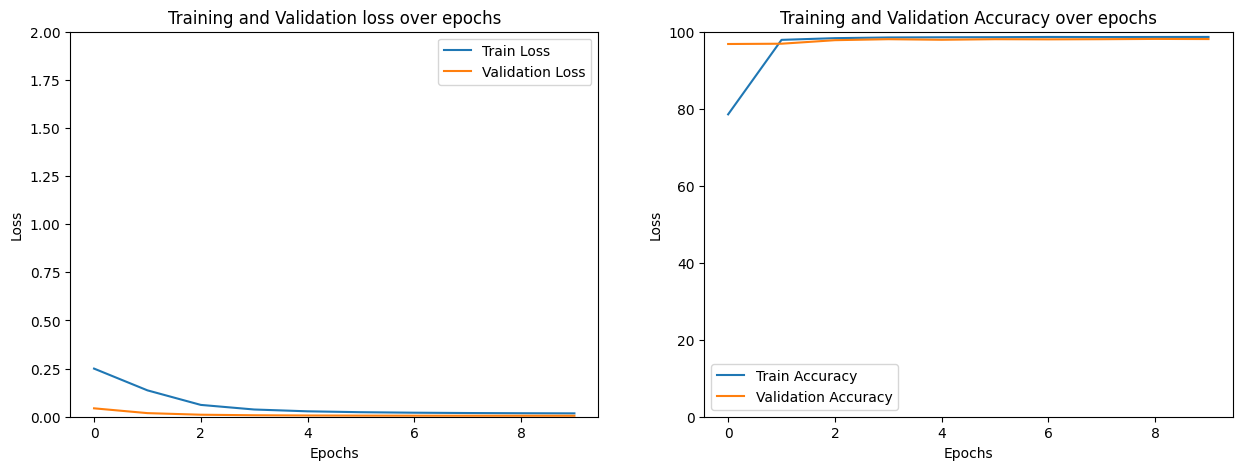

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label="Train Loss")
axs[0].plot(total_loss_val_plot, label="Validation Loss")
axs[0].set_title("Training and Validation loss over epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label="Train Accuracy")
axs[1].plot(total_acc_val_plot, label="Validation Accuracy")
axs[1].set_title("Training and Validation Accuracy over epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Loss")
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.show()

In [40]:
area = float(input("Area: "))/org_df['Area'].abs().max()
MajorAxisLength = float(input("Major Axis Length: "))/org_df['MajorAxisLength'].abs().max()
MinorAxisLength = float(input("Minor Axis Length: "))/org_df['MinorAxisLength'].abs().max()
Eccentricity = float(input("Eccentricity: "))/org_df['Eccentricity'].abs().max()
ConvexArea = float(input("Convex Area: "))/org_df['ConvexArea'].abs().max()
EquivDiameter = float(input("EquivDiameter: "))/org_df['EquivDiameter'].abs().max()
Extent = float(input("Extent: "))/org_df['Extent'].abs().max()
Perimeter = float(input("Perimeter: "))/org_df['Perimeter'].abs().max()
Roundness = float(input("Roundness: "))/org_df['Roundness'].abs().max()
AspectRation = float(input("AspectRation: "))/org_df['AspectRation'].abs().max()

my_inputs = [area, MajorAxisLength, MinorAxisLength, Eccentricity, ConvexArea, EquivDiameter, Extent, Perimeter, Roundness, AspectRation]

print("="*20)
model_inputs = torch.Tensor(my_inputs).to(device)
prediction = (model(model_inputs))
print(prediction)
print("Class is: ", round(prediction.item()))

Area: 2352
Major Axis Length: 81
Minor Axis Length: 42
Eccentricity: 32
Convex Area: 12
EquivDiameter: 33
Extent: 98
Perimeter: 927
Roundness: 627
AspectRation: 24
tensor([0.], device='cuda:0', grad_fn=<SigmoidBackward0>)
Class is:  0
